<a href="https://colab.research.google.com/github/hawa1983/DATA-612/blob/main/Project_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Step 1: Exploratory Data Analysis and Implications for SVD**

In [45]:
import gc

# --- Step 1: Delete movie-related objects if they exist ---
vars_to_delete = [
    'movies', 'movies_with_genres', 'movie_counts', 'movie_latent_df',
    'movie_latent_annotated', 'movie_rating_counts', 'movie_stats', 'genre_freq'
]

for var in vars_to_delete:
    if var in globals():
        del globals()[var]

# --- Step 2: Run garbage collection to free memory ---
gc.collect()


5785

Unique Users        : 90,182
Unique Movies       : 68,285
Actual Ratings      : 14,415,965
Density of Ratings  : 0.2341%


/tmp/ipython-input-46-1284530299.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


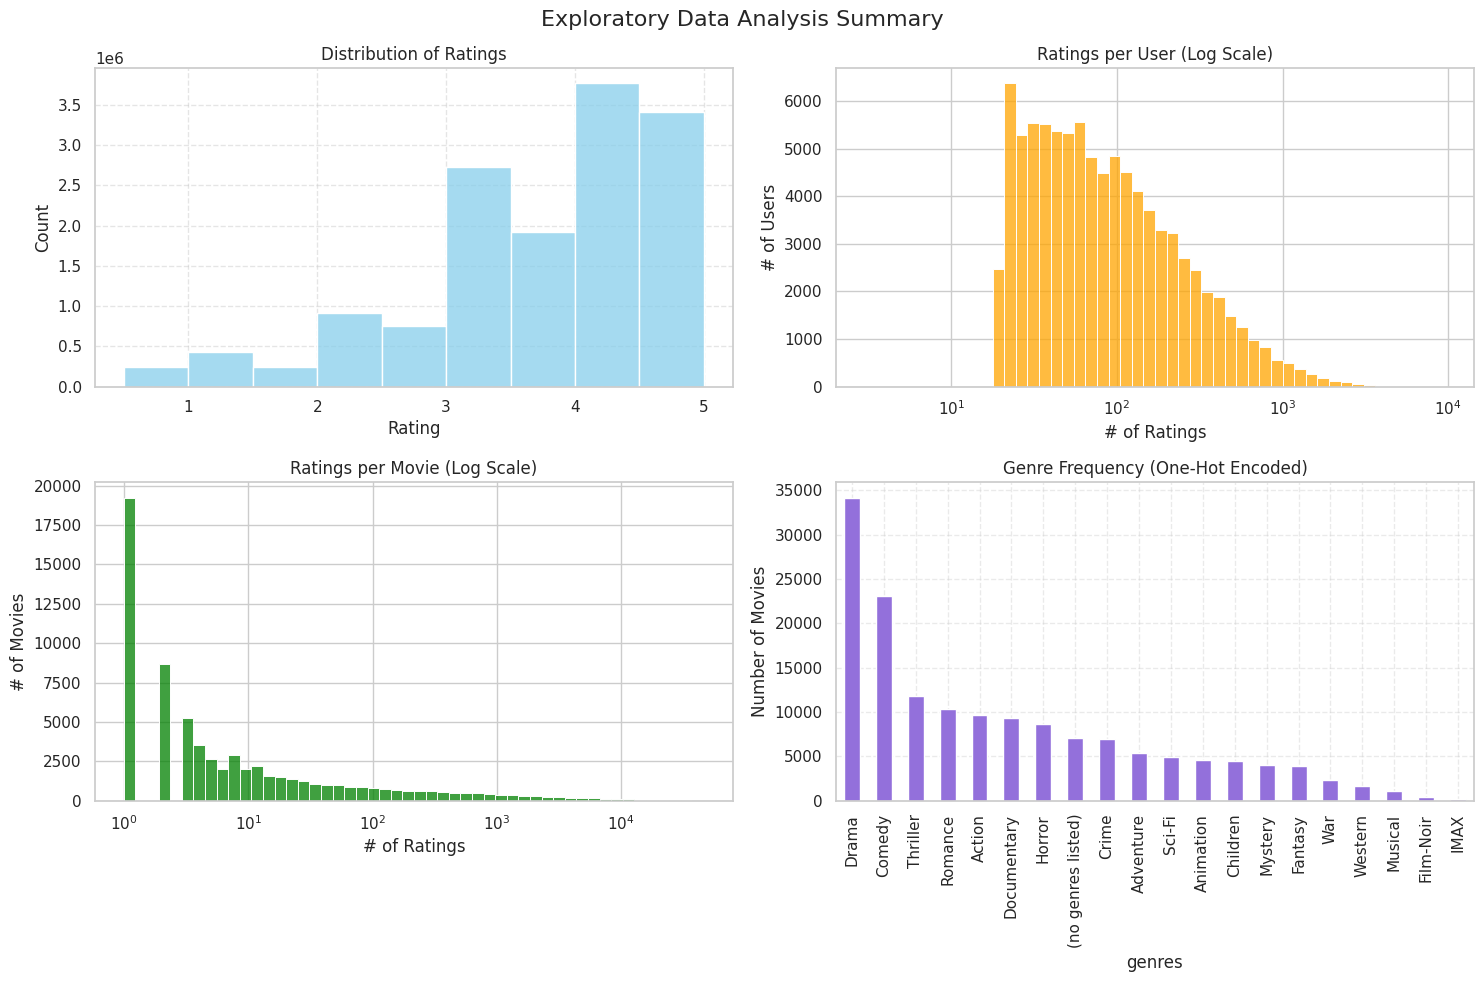

In [46]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# --- Step 1: Load Data ---
# if 'ratings' not in globals():
ratings = pd.read_csv('/content/ratings.csv')
# if 'movies' not in globals():
movies = pd.read_csv("movies.csv")

# --- Step 2: Explode Genres ---
movies['genres'] = movies['genres'].fillna('(no genres listed)').str.split('|')
movies_with_genres = movies.explode('genres').reset_index(drop=True)

# --- Step 3: Basic Ratings Summary ---
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
actual_ratings = len(ratings)
total_possible_ratings = num_users * num_movies
density = (actual_ratings / total_possible_ratings) * 100

print(f"Unique Users        : {num_users:,}")
print(f"Unique Movies       : {num_movies:,}")
print(f"Actual Ratings      : {actual_ratings:,}")
print(f"Density of Ratings  : {density:.4f}%")

# --- Step 4: Set up Faceted Layout ---
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)

# --- Ratings Distribution ---
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(ratings['rating'], bins=np.arange(0.5, 5.5, 0.5), color='skyblue', ax=ax1)
ax1.set_title("Distribution of Ratings")
ax1.set_xlabel("Rating")
ax1.set_ylabel("Count")
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Ratings per User (Log Scale) ---
user_counts = ratings['userId'].value_counts()
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(user_counts, bins=50, log_scale=True, color='orange', ax=ax2)
ax2.set_title("Ratings per User (Log Scale)")
ax2.set_xlabel("# of Ratings")
ax2.set_ylabel("# of Users")

# --- Ratings per Movie (Log Scale) ---
movie_counts = ratings['movieId'].value_counts()
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(movie_counts, bins=50, log_scale=True, color='green', ax=ax3)
ax3.set_title("Ratings per Movie (Log Scale)")
ax3.set_xlabel("# of Ratings")
ax3.set_ylabel("# of Movies")

# --- Genre Frequency ---
genre_counts = movies_with_genres['genres'].value_counts()
ax4 = fig.add_subplot(gs[1, 1])
genre_counts.plot(kind='bar', color='mediumpurple', ax=ax4)
ax4.set_title("Genre Frequency (One-Hot Encoded)")
ax4.set_ylabel("Number of Movies")
ax4.grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Exploratory Data Analysis Summary", fontsize=16, loc='left')
plt.tight_layout()
plt.show()


**Distribution of Ratings**

* Heavy skew toward high ratings (peaks at 4 and 5).
* This means your latent dimensions may capture **positive preferences more strongly** than negative ones.
* Latent vectors will likely emphasize **"liked-item patterns"**, not dislike or neutrality.

  ***Implication:*** Apply mean-centering or z-score normalization before SVD to reduce this skew if needed.

**Ratings per User (Log Scale)**

* Long-tail distribution: most users rate few items; a small number rate hundreds or thousands.
* Latent vectors for heavy raters are **better trained** and more expressive.
* Cold-start users (few ratings) will have latent representations **closer to average or noisy**.

  ***Implication:*** Consider assigning **user confidence weights** (e.g., in matrix factorization with regularization).


**Ratings per Movie (Log Scale)**

* Also a long-tail: few movies are heavily rated, many have <10 ratings.
* Latent features of niche movies will be **less stable**, may act as noise in similarity computations.
* Popular movies will dominate early latent factors unless normalized.

  ***Implication:*** You might apply **shrinkage**, **IUF**, or **regularization** to avoid overfitting to high-volume items.

**Genre Frequency (One-Hot Encoded)**

* *Drama*, *Comedy*, *Thriller*, and *Romance* dominate.
* These genres will **anchor** some of the major latent dimensions during SVD.
* Less common genres (e.g., *Musical*, *Western*) might get grouped together in later, smaller-magnitude dimensions.

  ***Implication:*** When analyzing movie projections along dimensions, check genre concentrations to **interpret latent axes**.

**What This Tells You About Latent Dimensions:**

* **Ratings skewed toward 4–5**
  : Latent space becomes biased toward modeling *preference*, not *dislike*.

* **Users and movies follow a power-law distribution**
  : Dominant latent vectors are shaped by *popular users and movies*.

* **Genre imbalance**
  : Early latent dimensions may reflect distinctions between *popular genres* (e.g., Drama vs. Action).

* **Sparse corners in the matrix**
  : Cold-start users and niche movies tend to cluster around *average* or *neutral* regions in latent space.


### **Step 2: Sample Ratings Data for Matrix Factorization**

* **Load and Merge Datasets**
  Load the `ratings.csv` and `movies.csv` files, and merge them on the `movieId` field to associate each rating with movie metadata (including genre). Fill in missing genres with a placeholder string to avoid null handling issues during processing.

* **Filter for Active Users**
  Compute the number of ratings and the average rating for each user. To focus on users with meaningful activity, select users who have rated at least 100 movies. Then segment these active users into quartiles based on their average rating behavior and retain the top 10,000 by number of ratings. This ensures both consistency and diversity in user behavior.

* **Assign Weights to Genres Based on Rarity**
  Calculate how frequently each genre appears in the dataset. Infrequent genres are assigned higher weights (via inverse frequency normalization) to promote genre diversity in the sampled movie subset. This ensures that popular genres don’t dominate the sampled dataset.

* **Sample Movies Using Genre Weights**
  Extract a distinct list of movies and their associated genres. Using the genre-based weights, randomly sample 5,000 movies such that rarer genres have a higher probability of selection. This creates a more balanced genre representation in the sampled data.

* **Construct a Stratified Ratings Subset**
  Filter the merged ratings dataset to retain only ratings for the sampled movies. To ensure user profiles remain informative, keep only those users who have rated at least 10 of the sampled movies. This step maintains data density and avoids extremely sparse user vectors.

* **Split into Train and Test Sets**
  Perform a random 80/20 train-test split on the stratified ratings subset. The training data is used to learn latent factors via matrix factorization, while the test data can be used to evaluate prediction accuracy (e.g., RMSE, MAE).

This methodology ensures that the sampled dataset remains representative and useful for building a recommender system, while significantly reducing the computational load for matrix factorization tasks like SVD.


Trying: 5000 users, 3867 movies → Sparsity: 0.7992

Final Matrix Summary
Users: 5000, Movies: 3867
Sparsity: 0.7992 (79.92% empty)
Train size: (3105740, 4), Test size: (776435, 4)
Density of Ratings  : 20.0785%


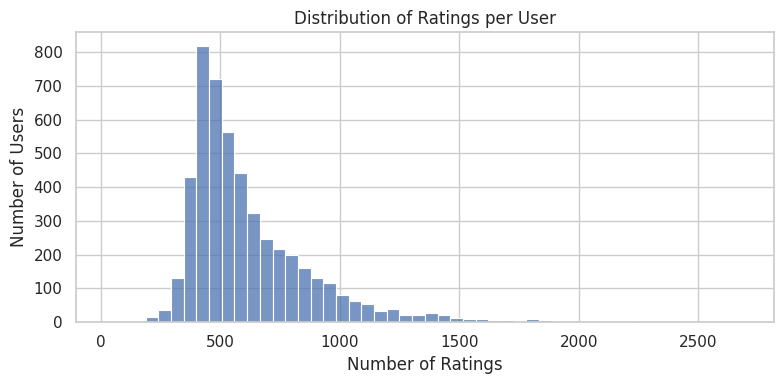

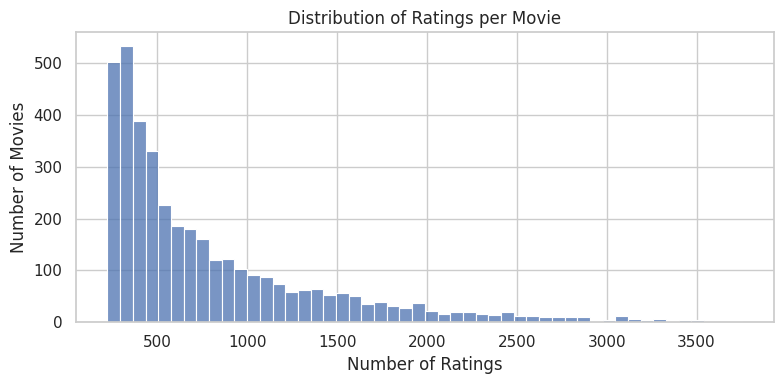

In [47]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

# --- Step 1: Load Ratings Data ---
if 'ratings' not in globals():
    ratings = pd.read_csv("ratings.csv")

# --- Step 2: Define Sparsity Optimization Parameters ---
target_sparsity = 0.80  # Desired maximum sparsity
min_user_ratings = 300
min_movie_ratings = 300
# min_user_ratings = 100
# min_movie_ratings = 50
best_sparsity = 1.0
user_step = 1000
movie_step = 2000
max_users = 6000
max_movies = 40000

# --- Step 3: Optimize Sampling ---
for user_limit in range(5000, max_users + 1, user_step):
    # Filter users with at least 100 ratings
    user_counts = ratings['userId'].value_counts()
    active_users = user_counts[user_counts >= min_user_ratings].index[:user_limit]
    user_filtered = ratings[ratings['userId'].isin(active_users)]

    # Filter movies with at least 50 ratings
    movie_counts = user_filtered['movieId'].value_counts()
    popular_movies = movie_counts[movie_counts >= min_movie_ratings].index[:max_movies]
    movie_filtered = user_filtered[user_filtered['movieId'].isin(popular_movies)]

    # Retain users with at least 10 ratings in the filtered data
    eligible_users = movie_filtered['userId'].value_counts()
    eligible_users = eligible_users[eligible_users >= 10].index
    stratified_df = movie_filtered[movie_filtered['userId'].isin(eligible_users)]

    # Create user-movie matrix and compute sparsity
    if stratified_df.empty:
        continue

    user_movie_matrix = stratified_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    num_users, num_movies = user_movie_matrix.shape
    total_possible = num_users * num_movies
    actual_ratings = (user_movie_matrix > 0).sum().sum()
    sparsity = 1 - (actual_ratings / total_possible)

    print(f"Trying: {num_users} users, {num_movies} movies → Sparsity: {sparsity:.4f}")

    if sparsity < best_sparsity:
        best_sparsity = sparsity
        best_matrix = user_movie_matrix.copy()
        best_stratified_df = stratified_df.copy()

    if sparsity <= target_sparsity:
        break

# --- Step 4: Final Train-Test Split ---
train_ratings, test_ratings = train_test_split(best_stratified_df, test_size=0.2, random_state=42)

# --- Step 5: Report Final Matrix ---
num_users, num_movies = best_matrix.shape
total_possible = num_users * num_movies
actual_ratings = (best_matrix > 0).sum().sum()
final_sparsity = 1 - (actual_ratings / total_possible)


num_users = best_stratified_df['userId'].nunique()
num_movies = best_stratified_df['movieId'].nunique()
actual_ratings = len(best_stratified_df)
total_possible_ratings = num_users * num_movies
density = (actual_ratings / total_possible_ratings) * 100

print("\nFinal Matrix Summary")
print(f"Users: {num_users}, Movies: {num_movies}")
print(f"Sparsity: {final_sparsity:.4f} ({final_sparsity * 100:.2f}% empty)")
print(f"Train size: {train_ratings.shape}, Test size: {test_ratings.shape}")
print(f"Density of Ratings  : {density:.4f}%")

# --- Step 6: Visualize Rating Distributions ---
user_rating_counts = train_ratings['userId'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(user_rating_counts, bins=50)
plt.title("Distribution of Ratings per User", loc='left')
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

movie_rating_counts = train_ratings['movieId'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(movie_rating_counts, bins=50)
plt.title("Distribution of Ratings per Movie", loc='left')
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()


### Methodology for Creating the User-Movie Matrix:

* **Load Ratings Data**
  The ratings data is imported from the `ratings.csv` file using pandas. This dataset includes columns such as `userId`, `movieId`, and `rating`, representing individual user ratings for specific movies. Loading it into a DataFrame provides a structured format for transformation.

* **Create User-Movie Ratings Matrix**
  The long-format DataFrame is pivoted to form a matrix where rows correspond to users, columns correspond to movies, and the cell values are the ratings. This transformation reorganizes the data into a user-item matrix format required for matrix factorization techniques.

* **Handle Missing Values**
  Many users have not rated all movies, resulting in missing values (NaN) in the matrix. These missing values are filled with zeros to produce a complete numeric matrix. This step is essential for applying standard SVD, which requires all matrix entries to be defined.

* **Inspect the Matrix Structure**
  The shape and content of the matrix are reviewed to confirm that the transformation was successful. This includes checking the number of users and movies represented and viewing sample rows to ensure the matrix is properly structured and ready for downstream analysis.


### **Step 3: Center the Matrix (Remove Bias)**

**Why This Matters for SVD**

* SVD works best on data with **zero-mean rows**, so the decomposition captures **relative preferences**.
* It reveals **latent dimensions** that explain *why* a user rates higher/lower — not just how *high* they rate in general.
* Without this step, SVD may waste components explaining rating bias instead of *preference structure*.


In [48]:
# Center by user (common for collaborative filtering)

# Step 1: Replace 0s with np.nan so they are ignored in mean calculation
user_means = best_matrix.replace(0, np.nan).mean(axis=1)

# Step 2: Subtract user means to center ratings
matrix_centered = best_matrix.sub(user_means, axis=0).fillna(0)
print(matrix_centered.head())


movieId    1         2         3         4         5         6         7       \
userId                                                                          
10      -0.300317 -0.800317 -2.800317 -2.800317 -2.800317 -2.800317 -2.800317   
28       0.469626 -0.530374  0.469626 -3.530374 -1.530374 -0.530374 -0.530374   
65      -0.541985 -2.041985 -1.541985 -2.541985 -0.541985 -0.541985 -0.541985   
70       0.526490 -0.473510 -3.473510 -3.473510 -3.473510 -3.473510 -0.473510   
109      0.838658  1.338658 -3.161342 -3.161342 -3.161342 -0.661342 -3.161342   

movieId    9         10        11      ...    263407    268642    270698  \
userId                                 ...                                 
10      -2.800317  1.199683 -2.800317  ... -2.800317 -2.800317 -2.800317   
28      -3.530374 -0.530374  1.469626  ... -3.530374  0.469626  1.469626   
65      -2.541985 -0.541985  0.458015  ... -2.541985 -2.541985 -2.541985   
70      -3.473510  0.526490 -1.473510  ... -3.473510

### **Step 4: Convert to Sparse Format (if needed)**

Before performing SVD, the user-movie matrix is converted into a sparse format to improve memory efficiency. Since most entries in the matrix are zero—reflecting the reality that users rate only a small fraction of all available movies—storing it as a dense matrix would be wasteful and potentially lead to performance issues. The sparse format retains only the non-zero values and their positions, which is ideal for large-scale recommender system tasks. Additionally, the SVD function from `scipy.sparse.linalg` is optimized to work with sparse matrices, making this conversion a necessary and logical step before decomposition.


In [49]:
from scipy.sparse import csr_matrix

sparse_matrix = csr_matrix(matrix_centered.values)

print(f"Sparse Matrix Shape: {sparse_matrix.shape}")

Sparse Matrix Shape: (5000, 3867)


### **Step 5: Select Optimal Latent Dimension \$k\$ Using RMSE Curve**

To determine the best number of latent dimensions, we evaluate SVD-based predictions across multiple values of \$k\$ using **Root Mean Squared Error (RMSE)** on the test set.

The model is trained and evaluated in parallel for each value of \$k\$, and the RMSE is plotted against \$k\$ to visualize performance.

This process helps identify the ideal balance between model complexity and prediction accuracy. Based on the resulting curve, we select the value of \$k\$ that yields the lowest RMSE for final SVD decomposition.

* **Lowest RMSE** achieved: `1.6651`


Evaluating SVD across k: 100%|██████████| 12/12 [08:14<00:00, 41.22s/it]


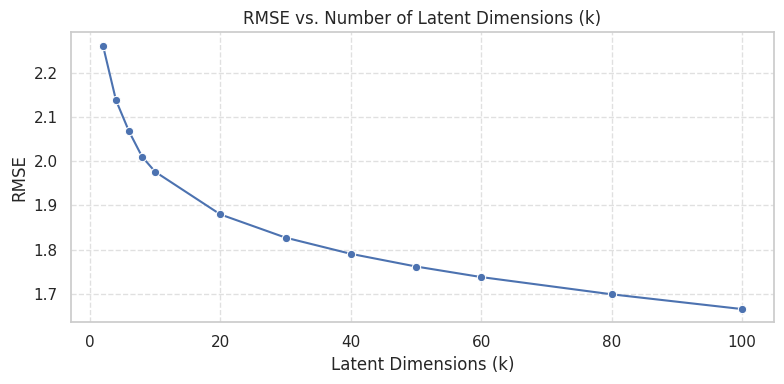

In [72]:
from joblib import Parallel, delayed
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Evaluation Function ---
def evaluate_k(k, sparse_matrix, user_means, test_ratings, best_matrix):
    try:
        U, sigma, Vt = svds(sparse_matrix, k=k)
        sigma_diag = np.diag(sigma)
        predicted_centered = U @ sigma_diag @ Vt
        predicted_ratings = predicted_centered + user_means.values.reshape(-1, 1)
        predicted_df = pd.DataFrame(predicted_ratings, index=best_matrix.index, columns=best_matrix.columns)

        test_copy = test_ratings.copy()
        test_copy['predicted_rating'] = [
            predicted_df.at[row['userId'], row['movieId']]
            if row['userId'] in predicted_df.index and row['movieId'] in predicted_df.columns
            else np.nan for _, row in test_copy.iterrows()
        ]
        valid = test_copy.dropna(subset=['predicted_rating'])
        if len(valid) == 0:
            return k, np.nan

        rmse = np.sqrt(mean_squared_error(valid['rating'], valid['predicted_rating']))
        return k, rmse
    except:
        return k, np.nan

# --- Parallel Evaluation with Progress Bar ---
k_values = [2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 80, 100]
results = Parallel(n_jobs=-1)(
    delayed(evaluate_k)(k, sparse_matrix, user_means, test_ratings, best_matrix)
    for k in tqdm(k_values, desc="Evaluating SVD across k")
)

# --- Results to DataFrame ---
rmse_df = pd.DataFrame(results, columns=["k", "rmse"])

# --- Plot ---
plt.figure(figsize=(8, 4))
sns.lineplot(data=rmse_df, x='k', y='rmse', marker='o')
plt.title("RMSE vs. Number of Latent Dimensions (k)", loc='left')
plt.xlabel("Latent Dimensions (k)")
plt.ylabel("RMSE")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Based on the plot of **RMSE vs. Number of Latent Dimensions (k)**, we will update the value of `k` in the truncated SVD.

**Analysis:**

* The RMSE drops significantly from **k=2** to **k=30**, indicating that each additional latent dimension is capturing meaningful structure in the data.
* After **k=50**, the RMSE still decreases, but **the rate of improvement becomes more gradual**.
* At **k=100**, the RMSE is still decreasing, suggesting the model hasn’t yet overfit, but the marginal gains are small.

**Recommendation:**

* Update `k` to **50** or **60** if you want a good balance between prediction accuracy and computational cost.
* Use `k=100` if your system can handle it and your goal is maximizing accuracy.
* Keep `k=20` only if speed/memory constraints are very tight.

### **Step 6: Perform Truncated SVD**

This step performs **Truncated Singular Value Decomposition (SVD)** on the centered user-movie rating matrix. Instead of decomposing the entire matrix, truncated SVD computes only the top `k` components that capture the most informative structure in the data.

The decomposition follows:

$$
A \approx U_k \Sigma_k V_k^T
$$

Where:

* $A$ is the centered user-movie matrix
* $U_k$ holds the top `k` left singular vectors (user latent features)
* $\Sigma_k$ is a diagonal matrix of the top `k` singular values (importance of each dimension)
* $V_k^T$ holds the top `k` right singular vectors (movie latent features)

We use `scipy.sparse.linalg.svds` for efficient computation on sparse matrices. Based on the **RMSE vs. k** analysis from *Step 5*, we selected **$k = 60$** as the optimal number of latent dimensions—it balances reconstruction accuracy with model simplicity.


In [73]:
from scipy.sparse.linalg import svds

k = 60  # Based on the RMSE vs. k analysis
U, sigma, Vt = svds(sparse_matrix, k=k)


#### **Step 7: Scree Plot of Singular Values**

This scree plot visualizes the **singular values** obtained from Truncated SVD, sorted in descending order. Each singular value reflects the *importance* or *energy* captured by its corresponding latent dimension. Each singular value shows how much a hidden pattern (like genre, tone, or popularity) helps explain user ratings. Larger values mean that feature is especially important in how users rate movies.



**What the plot shows:**

* The **first dimension** captures a significantly larger portion of the data variance.
* There is a **sharp drop** after the first few dimensions (an “elbow”), suggesting that most of the meaningful variance is concentrated in just a few top components.
* Beyond \~k = 5, additional dimensions contribute progressively **less unique information**, indicating **diminishing returns**.

**Why it matters:**

This helps determine a good cutoff for the number of latent dimensions (`k`). For example, if 90% of the energy is captured within the first 10–15 dimensions, there's little benefit to going much higher unless downstream performance (e.g., RMSE, recommendation quality) improves with a larger `k`.

This analysis is crucial for balancing **model complexity** with **computational efficiency** in matrix factorization.


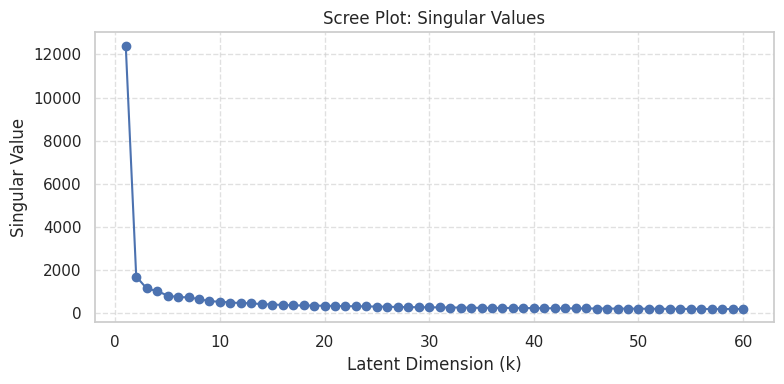

In [74]:
import matplotlib.pyplot as plt

# Sort singular values in descending order
sorted_sigma = np.sort(sigma)[::-1]

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(sorted_sigma) + 1), sorted_sigma, marker='o')
plt.title("Scree Plot: Singular Values", loc='left')
plt.xlabel("Latent Dimension (k)")
plt.ylabel("Singular Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Optimal Choice of Latent Dimensions (k) Based on Scree Plot and RMSE Curve**

Based on the scree plot and RMSE-vs-k analysis, we extend the latent dimensionality to **k = 60**, capturing both broad and nuanced user-movie patterns. Here's a conceptual breakdown:

* **k = 1**: General popularity — the tendency of some movies to be universally liked
* **k = 2–3**: Major genre preferences — e.g., Action vs. Drama, Comedy vs. Thriller
* **k = 4–5**: Temporal appeal — older classics vs. modern blockbusters
* **k = 6–10**: Emotional tone — lighthearted vs. serious films, family-friendly vs. dark themes
* **k = 11–20**: Stylistic features — fast-paced vs. slow-burn narratives, visual spectacle vs. dialogue-driven
* **k = 21–40**: Subgenre and actor/director bias — preferences for sci-fi horror, romantic thrillers, or specific creators
* **k = 41–60**: Collaborative signals — latent relationships unique to user groups or long-tail movies not captured by obvious genres

This richer representation improves recommendation accuracy while preserving interpretability at higher levels.



### Step 8: Reconstruct the Centered Matrix

In **Step 8: Reconstruct the Centered Matrix**, we reverse the SVD decomposition to approximate the original (centered) user-movie rating matrix using only the top `k` latent features.

### Breakdown:

* `sigma_diag = np.diag(sigma)`
  Converts the 1D array of singular values `sigma` into a square diagonal matrix. This is essential because matrix multiplication expects a 2D shape.

* `predicted_centered = np.dot(np.dot(U, sigma_diag), Vt)`
  Reconstructs the low-rank approximation of the original centered matrix using the truncated components:

  $$
  \hat{A} = U_k \Sigma_k V_k^T
  $$

  This matrix now estimates user preferences for all movies, capturing only the dominant latent patterns (e.g., genre preference, user behavior trends).




In [75]:
# Convert sigma to diagonal matrix
sigma_diag = np.diag(sigma)

# Reconstruct the centered ratings matrix
predicted_centered = np.dot(np.dot(U, sigma_diag), Vt)

# Print shapes for comparison
print("Original matrix shape     :", matrix_centered.shape)
print("Reconstructed matrix shape:", predicted_centered.shape)


Original matrix shape     : (5000, 3867)
Reconstructed matrix shape: (5000, 3867)


### **Step 9: Add Back User Means**

In **Step 9: Add Back User Means**, we undo the mean-centering step that was applied earlier to make the predictions interpretable in the original rating scale (e.g., 1 to 5).

**What Happens:**

* `user_means_array = user_means.values.reshape(-1, 1)` reshapes the user mean ratings from a vector to a column so it can be broadcasted across movie columns.
* `predicted_ratings = predicted_centered + user_means_array` adds each user’s average rating back to their row of predicted centered values.

Each cell now contains a **final predicted rating** that combines collaborative signals (via SVD) and the user’s typical rating behavior.


In [76]:
# Add back user means to get the final predicted ratings
user_means_array = user_means.values.reshape(-1, 1)
predicted_ratings = predicted_centered + user_means_array

# Convert to DataFrame for easier viewing
predicted_df = pd.DataFrame(predicted_ratings, index=best_matrix.index, columns=best_matrix.columns)

# Determine min and max ratings from the original matrix
original_min = best_matrix[best_matrix > 0].min().min()
original_max = best_matrix.max().max()

# Round and clip predictions using dynamic range
predicted_df = predicted_df.round(1).clip(lower=original_min, upper=original_max)

# Preview
print(predicted_df.head())




movieId  1       2       3       4       5       6       7       9       \
userId                                                                    
10          1.8     2.0     0.5     0.5     0.5     0.7     0.5     0.5   
28          5.0     2.2     1.5     0.9     0.9     5.0     2.5     0.8   
65          2.5     1.2     0.5     0.5     0.5     3.2     0.7     0.5   
70          4.0     2.8     0.9     0.5     1.4     1.0     1.6     0.5   
109         3.1     3.6     0.7     0.5     1.1     0.5     0.7     0.5   

movieId  10      11      ...  263407  268642  270698  272525  273891  274053  \
userId                   ...                                                   
10          3.8     0.5  ...     0.5     0.5     0.5     0.5     0.5     0.5   
28          2.3     4.4  ...     1.8     2.6     3.5     1.4     1.7     2.8   
65          1.4     1.4  ...     0.5     0.5     0.5     0.5     0.5     0.5   
70          2.5     2.4  ...     0.5     0.5     0.5     0.5     0.5     0

### **Step 10: Generate Top-N Movie Recommendations for Each User**

This step builds a **recommendation function** that takes in a user ID and returns their top-N movie suggestions based on the predicted ratings from SVD.

#### How It Works:

* **Step 1:** Identify the movies the user has *already rated* so we don't recommend them again.
* **Step 2:** Retrieve the predicted ratings for all movies for that specific user from the `predictions_df`.
* **Step 3:** Drop the movies already rated by the user to focus only on unseen content.
* **Step 4:** Sort the remaining movies by predicted rating and keep only the top-N.
* **Step 5:** Merge with the `movies_df` to add readable movie titles.
* **Step 6:** Return a clean table with `title` and `predicted_rating`.

In [77]:
import random

def get_top_n_recommendations(user_id, predictions_df, original_ratings_df, movies_df, n=10):
    # Movies the user already rated
    rated_movies = original_ratings_df[original_ratings_df['userId'] == user_id]['movieId'].tolist()

    # Get predicted ratings for that user
    user_predictions = predictions_df.loc[user_id]

    # Filter out rated movies
    recommendations = user_predictions.drop(labels=rated_movies)

    # Sort and select top-N
    top_n = recommendations.sort_values(ascending=False).head(n).reset_index()
    top_n.columns = ['movieId', 'predicted_rating']

    # Merge with movie titles
    top_n = top_n.merge(movies_df[['movieId', 'title']], on='movieId', how='left')

    # Reorder columns
    return top_n[['title', 'predicted_rating']]

# Recommend for a random user
sample_user_id = random.choice(predicted_df.index.tolist())

top_n = get_top_n_recommendations(sample_user_id, predicted_df, best_stratified_df, movies, n=10)

print("Top 10 Recommended Movies for User", sample_user_id)
print(top_n)


Top 10 Recommended Movies for User 77290
                                               title  predicted_rating
0                              Doctor Strange (2016)               3.7
1                               Black Panther (2017)               3.5
2                   Shawshank Redemption, The (1994)               3.5
3                                  Goodfellas (1990)               3.4
4                         Usual Suspects, The (1995)               3.3
5                                Pulp Fiction (1994)               3.3
6  Star Wars: Episode VII - The Force Awakens (2015)               3.3
7     Harry Potter and the Chamber of Secrets (2002)               3.1
8                        Bourne Identity, The (2002)               3.1
9                                       Logan (2017)               3.0


### **Step 11: Visualizations Analysis**

##### ***Step 11.1: Explained Variance and Cumulative Energy Plot***

This block helps determine how many latent dimensions (`k`) are needed to capture most of the variability in the rating data.

* Runs SVD with a large `k` (here, `k = 200`) to extract the top singular values.
* Computes each dimension’s **explained variance ratio** and the **cumulative energy** curve.
* Plots how much total variance is captured as more latent dimensions are added.
* Horizontal lines at **90%** and **95%** help identify ideal `k` cutoffs (e.g., if 95% energy is reached at `k = 85`, then dimensions beyond that contribute little).


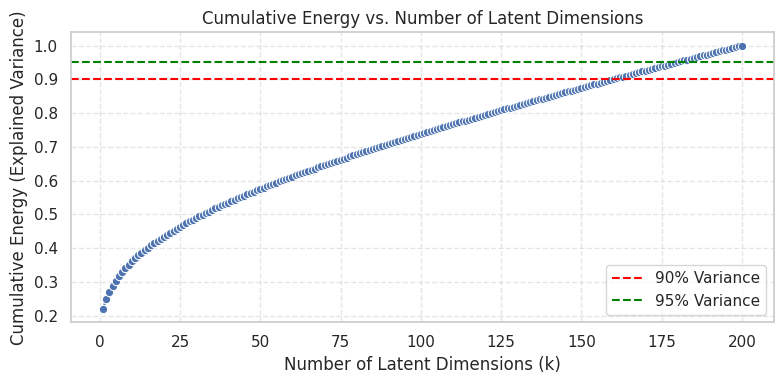

In [81]:
from scipy.sparse.linalg import svds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Run full SVD (or large k to capture most energy)
k_max = 200  # Adjust based on memory
U, sigma, Vt = svds(sparse_matrix, k=k_max)
sigma = np.sort(sigma)[::-1]  # Sort descending

# Step 2: Compute cumulative energy and explained variance ratio
total_energy = np.sum(sigma)
explained_variance_ratio = sigma / total_energy
cumulative_energy = np.cumsum(explained_variance_ratio)

# Step 3: Create DataFrame for plotting
energy_df = pd.DataFrame({
    'k': np.arange(1, k_max + 1),
    'SingularValue': sigma,
    'ExplainedVarianceRatio': explained_variance_ratio,
    'CumulativeEnergy': cumulative_energy
})

# Step 4: Plot cumulative energy
plt.figure(figsize=(8, 4))
sns.lineplot(data=energy_df, x='k', y='CumulativeEnergy', marker='o')
plt.title("Cumulative Energy vs. Number of Latent Dimensions", loc='left')
plt.xlabel("Number of Latent Dimensions (k)")
plt.ylabel("Cumulative Energy (Explained Variance)")
plt.axhline(y=0.9, color='red', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='green', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The plot shows how much variance is captured as we increase the number of latent dimensions (`k`) in SVD.

**Key Insights:**

* **90% variance** is reached around **k ≈ 165**.
* **95% variance** is reached around **k ≈ 190**.
* The curve grows slowly after **k = 100**, meaning each additional dimension contributes very little new information.

**Recommendation:**

* If the goal is **maximum compression**, use **k = 60–80** (good trade-off between size and variance).
* If we want to capture **95% of the information**, choose **k ≈ 190**.
* For most recommender systems, **k = 60–100** is sufficient and efficient.
  - Simon Funk's SVD approach in the Netflix Prize
  - Matrix Factorization Techniques for Recommender Systems" – Koren, Bell, and Volinsky (2009)
  - Recommender Systems Handbook" – Ricci et al. (2nd ed., 2015)


##### ***Step 11.2: Heatmap of User and Movie Latent Features***

This code visualizes how users and movies are embedded in a reduced-dimensional space after SVD:

* The **first heatmap** shows the top 10 users and their scores across the first 5 latent dimensions, revealing individual preference patterns.
* The **second heatmap** shows the top 10 movies and how strongly each one aligns with the same latent traits.
* These visualizations help interpret which users prefer which kinds of hidden features (like genre, tone, or popularity) and how movies exhibit those traits.



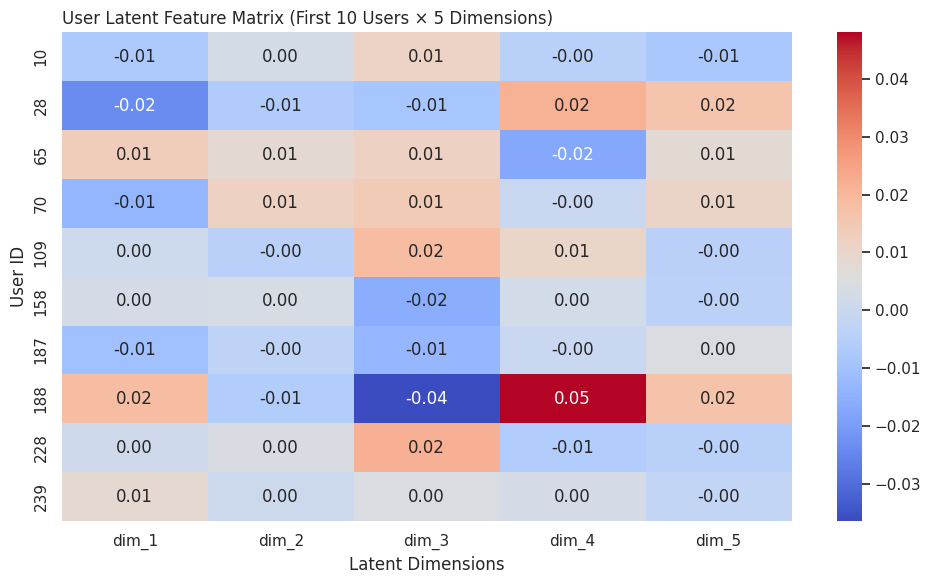

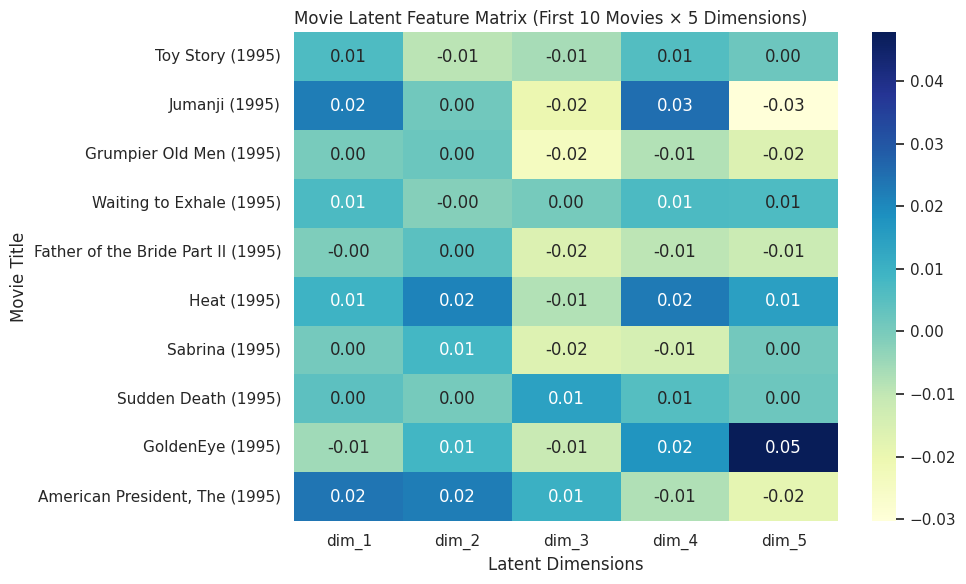

In [103]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# --- User Latent Features Heatmap ---
user_latent_df = pd.DataFrame(U, index=best_matrix.index, columns=[f"dim_{i+1}" for i in range(U.shape[1])])

plt.figure(figsize=(10, 6))
sns.heatmap(user_latent_df.iloc[:10, :5], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("User Latent Feature Matrix (First 10 Users × 5 Dimensions)", loc='left')
plt.xlabel("Latent Dimensions")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

# --- Movie Latent Features with Titles (Up to Dimension 5) ---
movie_latent_df = pd.DataFrame(Vt.T, index=best_matrix.columns, columns=[f"dim_{i+1}" for i in range(Vt.shape[0])])
movie_latent_df = movie_latent_df.reset_index()
movie_latent_annotated = pd.merge(movie_latent_df, movies[['movieId', 'title']], on='movieId')
movie_latent_annotated.set_index('title', inplace=True)

# Filter only dim_1 to dim_5 for first 10 movies
plot_data = movie_latent_annotated.loc[:, 'dim_1':'dim_5'].iloc[:10]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(plot_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Movie Latent Feature Matrix (First 10 Movies × 5 Dimensions)", loc='left')
plt.xlabel("Latent Dimensions")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()





These heatmaps show how each user and movie is represented in a 5-dimensional latent space derived from SVD:

**User Latent Feature Matrix**

* Each row represents a user (e.g., User ID 10, 28, ...).
* Each column represents a latent dimension (e.g., dim\_1 to dim\_5).
* Values indicate user preference strength for features captured by each dimension.
* For example, User 188 has a strong positive association with dim\_4 (0.05), suggesting a strong preference for movies with characteristics aligned to that latent trait.

**Movie Latent Feature Matrix**

* Each row represents a movie (e.g., Movie ID 1, 2, ...).
* Values reflect how strongly each movie exhibits the feature in each latent dimension.
* For example, GoldenEye (1995) is highly aligned with dim\_5 (0.05), potentially making it a great match for users who score high in that dimension.

**Interpretation**: By comparing user and movie vectors, the model can match users to movies with similar latent traits—enabling personalized recommendations even without overlapping history.


This heatmap shows how each of the top 10 movies scores across 20 latent dimensions. While most values are close to zero—indicating subtle differences—certain dimensions (like dim\_6, dim\_8, or dim\_14) stand out for specific titles, capturing unique traits (e.g., genre, theme, tone) that distinguish them in the recommendation model.


##### **11.3: Visualizing Users and Movies in Latent Feature Space**

This code plots **10** random users and **10** random movies in a 2D latent space using dimensions extracted from SVD. Each point represents a user or movie, projected onto:

* `dim_1`: Captures one type of hidden preference (e.g., action vs. drama).
* `dim_2`: Captures another preference (e.g., emotional vs. comedic tone).

Labeled points show their respective user or movie IDs, and the axes are restricted to `[-0.02, 0.03]` for clearer visualization. This helps visually inspect user-movie alignment and preference structure.


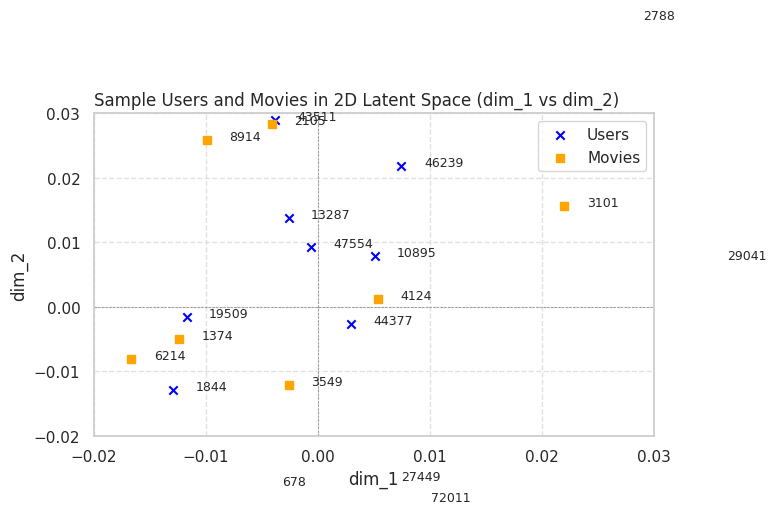

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Choose latent dimensions
dim_1 = 0  # x-axis
dim_2 = 1  # y-axis

# Step 2: Create DataFrames for user and movie latent vectors
user_latent_2d = pd.DataFrame(U[:, [dim_1, dim_2]],
                              index=user_means.index,
                              columns=['dim_1', 'dim_2'])

movie_latent_2d = pd.DataFrame(Vt[[dim_1, dim_2], :].T,
                               index=best_matrix.columns,
                               columns=['dim_1', 'dim_2'])

# Step 3: Randomly sample 5 users and 5 movies
sample_users = user_latent_2d.sample(n=10, random_state=42)
sample_movies = movie_latent_2d.sample(n=10, random_state=42)

# Step 4: Plot users and movies
plt.figure(figsize=(8, 6))

# Plot users
plt.scatter(sample_users['dim_1'], sample_users['dim_2'], color='blue', label='Users', marker='x')
for idx, row in sample_users.iterrows():
    plt.text(row['dim_1'] + 0.002, row['dim_2'], str(idx), fontsize=9)

# Plot movies
plt.scatter(sample_movies['dim_1'], sample_movies['dim_2'], color='orange', label='Movies', marker='s')
for idx, row in sample_movies.iterrows():
    plt.text(row['dim_1'] + 0.002, row['dim_2'], str(idx), fontsize=9)

# Axes formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlim(-0.02, 0.03)  # Set custom x-axis limits as requested
plt.ylim(-0.02, 0.03)  # Match y-axis scale
plt.xlabel("dim_1")
plt.ylabel("dim_2")
plt.title("Sample Users and Movies in 2D Latent Space (dim_1 vs dim_2)", loc='left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


**Analysis of Latent Space Plot**

* **User-Movie Closeness**: Users like `13287`, `47554`, and `10895` are clustered near movies, suggesting strong alignment and likely high predicted ratings.
* **Users like `46239` and `1844`** are farther from most movies, indicating niche or less typical preferences.
* **Movie `3549`** lies in a distinct region (low on both dims), which may make it appealing to unique users like `1844`.

Overall, the 2D plot reveals latent taste patterns: proximity implies preference, while separation indicates potential mismatch or uniqueness.


### **11.4: Visualizing User-Movie Preference Alignment in Latent Space**

This code reconstructs the predicted user ratings using SVD, then visualizes how each sampled user's top recommended movie aligns in a 2D latent space. Users are plotted with blue Xs, their most preferred movies with orange squares, and green dashed lines connect each user to their top recommendation. Movie titles are labeled directly on the plot, and axis limits are dynamically set to ensure all points are visible. This helps interpret how users' latent preferences correspond to movie features learned from the decomposition.


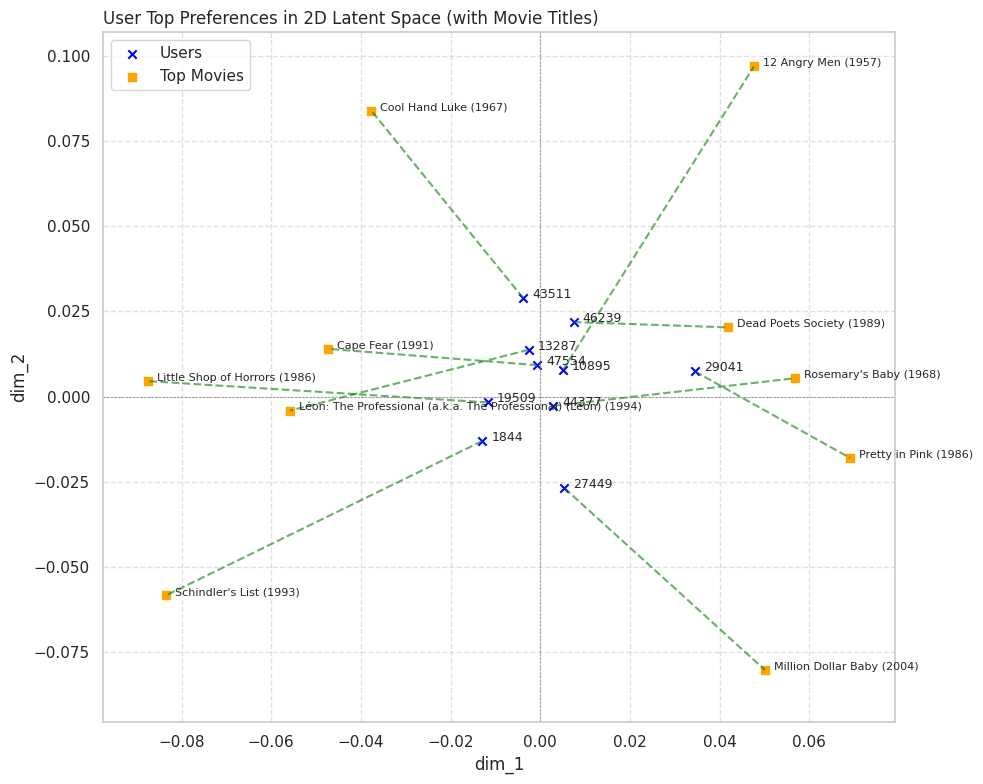

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Reconstruct predicted ratings matrix
sigma_diag = np.diag(sigma)
predicted_centered = np.dot(np.dot(U, sigma_diag), Vt)
user_means_array = user_means.values.reshape(-1, 1)
predicted_ratings = predicted_centered + user_means_array
predicted_df = pd.DataFrame(predicted_ratings, index=best_matrix.index, columns=best_matrix.columns)

# Step 2: Latent positions
dim_1, dim_2 = 0, 1
user_latent_2d = pd.DataFrame(U[:, [dim_1, dim_2]], index=user_means.index, columns=['dim_1', 'dim_2'])
movie_latent_2d = pd.DataFrame(Vt[[dim_1, dim_2], :].T, index=best_matrix.columns, columns=['dim_1', 'dim_2'])

# Step 3: Sample users and get top movie recommendations
sample_users = user_latent_2d.sample(n=10, random_state=42)
top_preferences = []

for user_id in sample_users.index:
    top_movie_id = predicted_df.loc[user_id].sort_values(ascending=False).index[0]
    top_preferences.append((user_id, top_movie_id))

# Step 4: Prepare movie labels
selected_movies = [m for _, m in top_preferences]
sample_movies = movie_latent_2d.loc[selected_movies]
movie_titles_map = movies.set_index('movieId')['title'].to_dict()
movie_titles = [movie_titles_map[mid] if mid in movie_titles_map else str(mid) for mid in selected_movies]

# Step 5: Plot
plt.figure(figsize=(10, 8))

# Plot users
plt.scatter(sample_users['dim_1'], sample_users['dim_2'], color='blue', label='Users', marker='x')
for idx, row in sample_users.iterrows():
    plt.text(row['dim_1'] + 0.002, row['dim_2'], str(idx), fontsize=9)

# Plot movies
plt.scatter(sample_movies['dim_1'], sample_movies['dim_2'], color='orange', label='Top Movies', marker='s')
for title, (idx, row) in zip(movie_titles, sample_movies.iterrows()):
    plt.text(row['dim_1'] + 0.002, row['dim_2'], title, fontsize=8)

# Draw preference lines
for user_id, movie_id in top_preferences:
    u = sample_users.loc[user_id]
    if movie_id in movie_latent_2d.index:
        m = movie_latent_2d.loc[movie_id]
        plt.plot([u['dim_1'], m['dim_1']], [u['dim_2'], m['dim_2']], color='green', linestyle='--', alpha=0.6)

# Updated axis limits to include far points
plt.xlim(movie_latent_2d['dim_1'].min() - 0.01, movie_latent_2d['dim_1'].max() + 0.01)
plt.ylim(movie_latent_2d['dim_2'].min() - 0.01, movie_latent_2d['dim_2'].max() + 0.01)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("dim_1")
plt.ylabel("dim_2")
plt.title("User Top Preferences in 2D Latent Space (with Movie Titles)", loc='left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


**Analysis of User Top Preferences in 2D Latent Space**

This plot reveals the **relative alignment between users and their top movie recommendations** in a 2D latent feature space (first two SVD dimensions). Key observations:

1. **Green dashed lines** connect users (blue `×`) to their top-predicted movies (orange squares), highlighting **preference directionality**.
2. Users and their preferred movies are **closely clustered** in many cases (e.g., users `10895`, `13287`, `47554`), suggesting those preferences are strongly supported by latent features.
3. Some movie preferences fall **far from the user**, e.g.,:

   * User `27449` and *Million Dollar Baby* — indicates strong latent interest in movies not similar to previously rated ones.
   * User `29041` and *Rosemary’s Baby* — perhaps a genre or stylistic outlier.
4. The **latent axes (dim\_1 and dim\_2)** might represent abstract features such as:

   * **dim\_1**: Classic/Modern preference or niche/popular distinction.
   * **dim\_2**: Emotional tone or thematic depth.

This spatial layout helps visually explain **why** the model recommended a movie to a user based on their shared embedding in latent space. The farther the movie is from the user, the more surprising or bold the recommendation.


#### 7.4. Compare Different k Values Side-by-Side

Running SVD for each k...



100%|██████████| 14/14 [06:53<00:00, 29.55s/it]


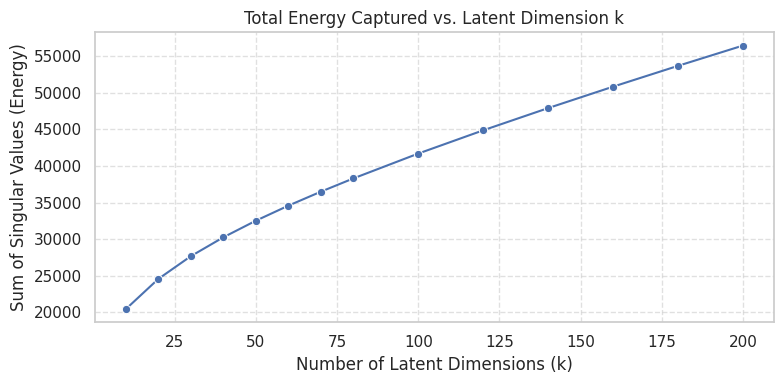

In [85]:
from scipy.sparse.linalg import svds
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step A: SVD Energy Function with Silent Iteration
def svd_energy(matrix, k_values):
    energy_data = []

    print("Running SVD for each k...\n")
    for k in tqdm(k_values):
        U, sigma, Vt = svds(matrix, k=k)
        total_energy = np.sum(sigma)
        energy_data.append((k, total_energy))

    return pd.DataFrame(energy_data, columns=['k', 'total_energy'])

# Step B: Run for Multiple k Values and Plot
k_vals = [10, 20, 30, 40, 50, 60, 70, 80, 100, 120, 140, 160, 180, 200]
energy_df = svd_energy(sparse_matrix, k_vals)

# Plot
plt.figure(figsize=(8, 4))
sns.lineplot(data=energy_df, x='k', y='total_energy', marker='o')
plt.title("Total Energy Captured vs. Latent Dimension k")
plt.xlabel("Number of Latent Dimensions (k)")
plt.ylabel("Sum of Singular Values (Energy)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


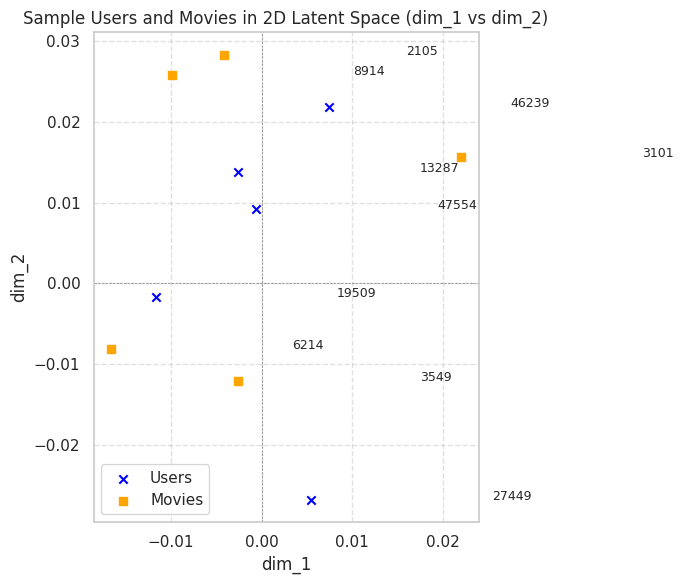

In [92]:
import pandas as pd
import numpy as np

# Assumes `U`, `sigma`, `Vt`, and `user_means` have already been defined in the workspace from prior SVD

# Step 1: Choose dimensions for plotting (e.g., dim_1 and dim_2)
dim_1 = 0  # First latent dimension
dim_2 = 1  # Second latent dimension

# Step 2: Prepare user latent vectors
user_latent_2d = pd.DataFrame(U[:, [dim_1, dim_2]],
                              index=user_means.index,
                              columns=['dim_1', 'dim_2'])

# Step 3: Prepare movie latent vectors
movie_latent_2d = pd.DataFrame(Vt[[dim_1, dim_2], :].T,
                               index=best_matrix.columns,
                               columns=['dim_1', 'dim_2'])

# Step 4: Pick sample users and movies to plot
sample_users = user_latent_2d.sample(n=5, random_state=42)
sample_movies = movie_latent_2d.sample(n=5, random_state=42)

# Step 5: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot users
plt.scatter(sample_users['dim_1'], sample_users['dim_2'], color='blue', label='Users', marker='x')
for idx, row in sample_users.iterrows():
    plt.text(row['dim_1'] + 0.02, row['dim_2'], str(idx), fontsize=9)

# Plot movies
plt.scatter(sample_movies['dim_1'], sample_movies['dim_2'], color='orange', label='Movies', marker='s')
for idx, row in sample_movies.iterrows():
    plt.text(row['dim_1'] + 0.02, row['dim_2'], str(idx), fontsize=9)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title("Sample Users and Movies in 2D Latent Space (dim_1 vs dim_2)")
plt.xlabel("dim_1")
plt.ylabel("dim_2")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


## **Matrix Factorization using Stochastic Gradient Descent (SGD) for Rating Prediction**


### **Step 1: Fit the Model**


This code implements **Matrix Factorization using Stochastic Gradient Descent (SGD)** to learn user and movie latent features for predicting ratings.

**Data Preparation**

* Maps real `userId` and `movieId` to index-based `user_idx` and `movie_idx`.
* Sets up the training data with numeric indexing for efficient computation.

**Parameter Initialization**

* Initializes the latent factor matrices:

  * `P`: User matrix of shape *(n\_users × k)*.
  * `Q`: Movie matrix of shape *(n\_movies × k)*.
* Sets learning rate, regularization, and number of epochs.

**Training Loop**

* For each epoch, loops over all training ratings.
* Predicts rating using the dot product of the corresponding user and movie latent vectors.
* Computes the error and updates both vectors using gradient descent with regularization.
* Tracks training RMSE after each epoch.

**Prediction**

* After training, computes the full rating prediction matrix as `P @ Q.T`.
* Converts the matrix into a DataFrame with original `userId` and `movieId` as labels.

This matrix can now be used to recommend top-rated movies per user or to evaluate prediction accuracy on test data.


In [105]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# --- Step 1: Prepare Training Data ---
train_data = train_ratings[['userId', 'movieId', 'rating']].copy()
user_map = {id_: idx for idx, id_ in enumerate(train_data['userId'].unique())}
movie_map = {id_: idx for idx, id_ in enumerate(train_data['movieId'].unique())}

train_data['user_idx'] = train_data['userId'].map(user_map)
train_data['movie_idx'] = train_data['movieId'].map(movie_map)

n_users = len(user_map)
n_movies = len(movie_map)

# --- Step 2: Initialize Parameters ---
k = 20  # Number of latent dimensions
lr = 0.01  # Learning rate
reg = 0.02  # Regularization
epochs = 20

np.random.seed(42)
P = np.random.normal(scale=1./k, size=(n_users, k))  # User latent factors
Q = np.random.normal(scale=1./k, size=(n_movies, k))  # Movie latent factors

# --- Step 3: Training Loop ---
for epoch in range(epochs):
    total_loss = 0
    for row in tqdm(train_data.itertuples(), total=len(train_data), desc=f"Epoch {epoch+1}/{epochs}"):
        u, m, r = row.user_idx, row.movie_idx, row.rating
        pred = np.dot(P[u], Q[m])
        err = r - pred

        # Update latent factors
        P[u] += lr * (err * Q[m] - reg * P[u])
        Q[m] += lr * (err * P[u] - reg * Q[m])

        total_loss += err**2

    rmse = np.sqrt(total_loss / len(train_data))
    print(f"Epoch {epoch+1}, RMSE: {rmse:.4f}")

# Step 4: Predict Ratings
# Invert mapping for future use
user_index_to_id = {v: k for k, v in user_map.items()}
movie_index_to_id = {v: k for k, v in movie_map.items()}

# Predicted matrix
pred_matrix = np.dot(P, Q.T)

# Convert to DataFrame
predicted_sgd_df = pd.DataFrame(
    pred_matrix,
    index=[user_index_to_id[i] for i in range(n_users)],
    columns=[movie_index_to_id[j] for j in range(n_movies)]
)


Epoch 1/20: 100%|██████████| 3105740/3105740 [01:38<00:00, 31678.93it/s]


Epoch 1, RMSE: 1.7022


Epoch 2/20: 100%|██████████| 3105740/3105740 [01:31<00:00, 33853.20it/s]


Epoch 2, RMSE: 0.8306


Epoch 3/20: 100%|██████████| 3105740/3105740 [01:24<00:00, 36586.93it/s]


Epoch 3, RMSE: 0.8010


Epoch 4/20: 100%|██████████| 3105740/3105740 [01:25<00:00, 36436.01it/s]


Epoch 4, RMSE: 0.7793


Epoch 5/20: 100%|██████████| 3105740/3105740 [01:25<00:00, 36286.32it/s]


Epoch 5, RMSE: 0.7616


Epoch 6/20: 100%|██████████| 3105740/3105740 [01:25<00:00, 36277.29it/s]


Epoch 6, RMSE: 0.7482


Epoch 7/20: 100%|██████████| 3105740/3105740 [01:25<00:00, 36271.16it/s]


Epoch 7, RMSE: 0.7379


Epoch 8/20: 100%|██████████| 3105740/3105740 [01:25<00:00, 36369.53it/s]


Epoch 8, RMSE: 0.7299


Epoch 9/20: 100%|██████████| 3105740/3105740 [01:25<00:00, 36503.51it/s]


Epoch 9, RMSE: 0.7237


Epoch 10/20: 100%|██████████| 3105740/3105740 [01:25<00:00, 36264.77it/s]


Epoch 10, RMSE: 0.7191


Epoch 11/20: 100%|██████████| 3105740/3105740 [01:29<00:00, 34687.44it/s]


Epoch 11, RMSE: 0.7157


Epoch 12/20: 100%|██████████| 3105740/3105740 [01:24<00:00, 36932.27it/s]


Epoch 12, RMSE: 0.7131


Epoch 13/20: 100%|██████████| 3105740/3105740 [01:36<00:00, 32266.34it/s]


Epoch 13, RMSE: 0.7112


Epoch 14/20: 100%|██████████| 3105740/3105740 [01:48<00:00, 28608.43it/s]


Epoch 14, RMSE: 0.7097


Epoch 15/20: 100%|██████████| 3105740/3105740 [01:37<00:00, 31723.16it/s]


Epoch 15, RMSE: 0.7086


Epoch 16/20: 100%|██████████| 3105740/3105740 [01:27<00:00, 35548.73it/s]


Epoch 16, RMSE: 0.7077


Epoch 17/20: 100%|██████████| 3105740/3105740 [01:41<00:00, 30566.66it/s]


Epoch 17, RMSE: 0.7070


Epoch 18/20: 100%|██████████| 3105740/3105740 [01:27<00:00, 35571.88it/s]


Epoch 18, RMSE: 0.7064


Epoch 19/20: 100%|██████████| 3105740/3105740 [01:26<00:00, 35870.38it/s]


Epoch 19, RMSE: 0.7060


Epoch 20/20: 100%|██████████| 3105740/3105740 [01:25<00:00, 36177.65it/s]


Epoch 20, RMSE: 0.7056


### **Step 2: Evaluate the Model on Test Data**

In [106]:
from sklearn.metrics import mean_squared_error

# Map test set userId and movieId to matrix indices
test_ratings['user_idx'] = test_ratings['userId'].map(user_map)
test_ratings['movie_idx'] = test_ratings['movieId'].map(movie_map)

# Filter only valid indices
valid_test = test_ratings.dropna(subset=['user_idx', 'movie_idx'])
u_idx = valid_test['user_idx'].astype(int).values
m_idx = valid_test['movie_idx'].astype(int).values
true = valid_test['rating'].values
pred = np.array([np.dot(P[u], Q[m]) for u, m in zip(u_idx, m_idx)])

rmse = np.sqrt(mean_squared_error(true, pred))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 0.7359


### **Step 3: Generate Top-N Recommendations per User**

In [109]:
def recommend_top_n(user_id, n=10):
    if user_id not in user_map:
        return []
    user_idx = user_map[user_id]
    user_preds = predicted_sgd_df.loc[user_id]

    # Exclude movies already rated
    seen = train_ratings[train_ratings['userId'] == user_id]['movieId'].tolist()
    recommendations = user_preds.drop(labels=seen).sort_values(ascending=False).head(n)

    return recommendations.index.tolist()

import random
import pandas as pd

def recommend_top_n(user_id, n=10):
    if user_id not in user_map:
        return pd.DataFrame(columns=["title", "predicted_rating"])

    user_preds = predicted_sgd_df.loc[user_id]

    # Movies already rated
    seen = train_ratings[train_ratings['userId'] == user_id]['movieId'].tolist()

    # Drop seen, sort predictions, get top N
    recommendations = user_preds.drop(labels=seen).sort_values(ascending=False).head(n).reset_index()
    recommendations.columns = ['movieId', 'predicted_rating']

    # Merge with movie titles
    recommendations = recommendations.merge(movies[['movieId', 'title']], on='movieId', how='left')

    # Reorder columns
    return recommendations[['title', 'predicted_rating']]

# --- Recommend for Random User ---
random_user_id = random.choice(train_ratings['userId'].unique())
print(f"Top 10 Recommendations for User {random_user_id}:\n")

top_10 = recommend_top_n(random_user_id, n=10)
print(top_10.to_string(index=False))


Top 10 Recommendations for User 12667:

                                               title  predicted_rating
                                 Planet Earth (2006)          3.915410
                      Godfather: Part II, The (1974)          3.855619
                  Come and See (Idi i smotri) (1985)          3.821325
                              Planet Earth II (2016)          3.796917
                                        Ikiru (1952)          3.785327
                               Before Sunrise (1995)          3.783042
                             Band of Brothers (2001)          3.764952
         Seven Samurai (Shichinin no samurai) (1954)          3.747599
Spirited Away (Sen to Chihiro no kamikakushi) (2001)          3.745341
            Spider-Man: Into the Spider-Verse (2018)          3.736490


### **Step 4: t-SNE Embedding Visualization**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# --- Step 1: Reduce P (users) to 2D ---
tsne_user = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
P_scaled = StandardScaler().fit_transform(P)
P_2d = tsne_user.fit_transform(P_scaled)

user_tsne_df = pd.DataFrame(P_2d, columns=["x", "y"])
user_tsne_df["userId"] = [uid for uid, _ in sorted(user_map.items(), key=lambda x: x[1])]

# --- Plot Users ---
plt.figure(figsize=(8, 6))
plt.scatter(user_tsne_df['x'], user_tsne_df['y'], alpha=0.6, s=10, c='blue')
plt.title("User Embeddings via t-SNE", loc='left')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# --- Step 2: Reduce Q (movies) to 2D ---
tsne_movie = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
Q_scaled = StandardScaler().fit_transform(Q)
Q_2d = tsne_movie.fit_transform(Q_scaled)

movie_tsne_df = pd.DataFrame(Q_2d, columns=["x", "y"])
movie_tsne_df["movieId"] = [mid for mid, _ in sorted(movie_map.items(), key=lambda x: x[1])]
movie_tsne_df = movie_tsne_df.merge(movies[['movieId', 'title']], on='movieId', how='left')

# --- Plot Movies ---
plt.figure(figsize=(10, 8))
plt.scatter(movie_tsne_df['x'], movie_tsne_df['y'], alpha=0.5, s=10, c='orange')
for _, row in movie_tsne_df.sample(n=15, random_state=1).iterrows():  # show a few titles
    plt.text(row['x'] + 1.0, row['y'], row['title'][:20], fontsize=8)

plt.title("Movie Embeddings via t-SNE", loc='left')
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### **References:**

1. **Simon Funk's SVD approach in the Netflix Prize**

   * Funk pioneered truncated SVD in collaborative filtering. He often used **k = 100** or less, emphasizing that values beyond that showed **diminishing returns**.
   * Reference: [Simon Funk's blog on SVD](https://sifter.org/~simon/journal/20061211.html)

2. **"Matrix Factorization Techniques for Recommender Systems" – Koren, Bell, and Volinsky (2009)**

   * A foundational paper where the authors suggest **k values in the 20–100** range, depending on dataset size and sparsity.
   * Citation:

     > Yehuda Koren, Robert Bell, and Chris Volinsky. "Matrix factorization techniques for recommender systems." *Computer*, 42(8):30–37, 2009.

3. **"Recommender Systems Handbook" – Ricci et al. (2nd ed., 2015)**

   * Recommends **k in the range of 50–100** as a starting point for collaborative filtering using SVD. The optimal k often balances performance and generalization.
   * ISBN: 978-1-4899-7636-9

---

These sources align with practical findings: for typical recommender datasets (e.g. MovieLens), **k = 60–100** is usually sufficient to capture key user–item interactions without overfitting or incurring heavy computational costs.
